# Time-lagged Auto Encoder

### Introduction

### Import

In [1]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## TICA & DeepTICA on Muller-Brown potential (high temperature MD)

### Load data

In [16]:
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictionaryDataModule

filenames = [ "data/muller-brown/unbiased/high-temp/COLVAR" ]

# load file
df = load_dataframe(filenames)

# get descriptors
X = df.filter(regex='p.x|p.y').values

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,lag_time=1)

# specify target data
dataset['target'] = dataset['data_lag']

# create datamodule
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2]) #,random_split=False,shuffle=False)

/home/lbonati@iit.local/work/code/mlcolvar/mlcolvar/utils/timelagged.py:129: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn('Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.')


#### Define model

In [10]:
from mlcolvar.cvs import AutoEncoderCV

n_components = 2
encoder_layers = [2,30,30,n_components]
nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = AutoEncoderCV (encoder_layers, options=options )
model

AutoEncoderCV(
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=30, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=30, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
)

#### Define Trainer & Fit

In [11]:
from lightning.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=20)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [2]      | [2]      
1 | encoder | FeedForward   | 1.1 K  | [2]      | [2]      
2 | decoder | FeedForward   | 1.1 K  | ?        | ?        
-------------

Epoch 107: 100%|██████████| 2/2 [00:00<00:00, 152.26it/s, loss=0.0438]      


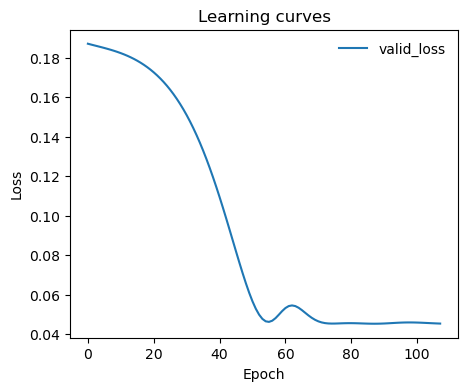

In [12]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Normalize output

In [13]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm
#print(Statistics(s))

#### Plot CVs isolines

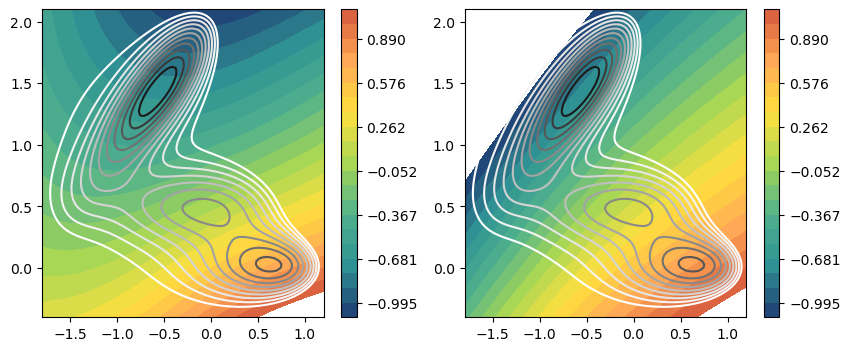

In [14]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24,12), mode='contour', ax=ax)
    plot_isolines_2D(model, component=i, levels=np.linspace(-1.1,1.1,22), ax=ax)
    #plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

#### Plot FES

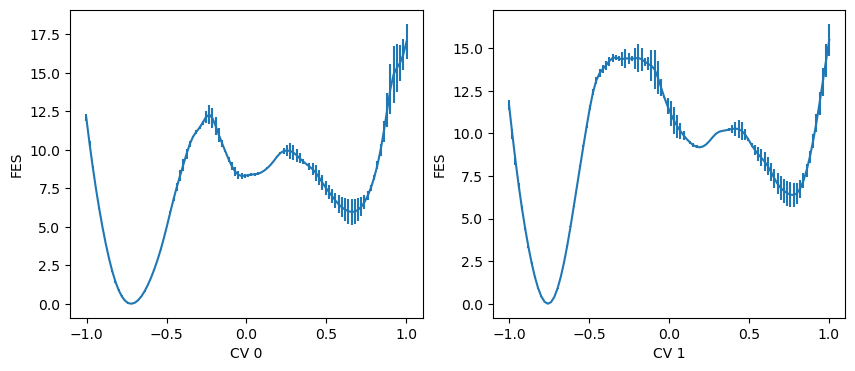

In [15]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    fes,grid,bounds,std = compute_fes(s[:,i], kbt=2.5, plot=True, scale_by='range', bandwidth=0.02, blocks=2, plot_max_fes=30, ax=ax )
    ax.set_xlabel(f'CV {i}')